In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline

from aux_fun import *

In [2]:
pos_image_fnames = glob.glob('data/vehicles/KITTI_extracted/*.png')
neg_image_fnames = glob.glob('data/non-vehicles/Extras/extra*.png')

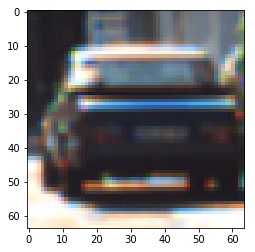

In [3]:
test_pos_img = io.imread(pos_image_fnames[0])
plt.imshow(test_pos_img)

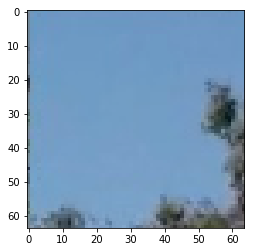

In [4]:
test_neg_img = io.imread(neg_image_fnames[0])
plt.imshow(test_neg_img)

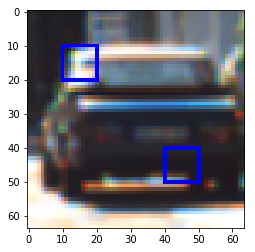

In [5]:
plt.imshow(draw_boxes(test_pos_img, [((10, 10), (20,20)), ((40,40),(50,50))], thick=1))

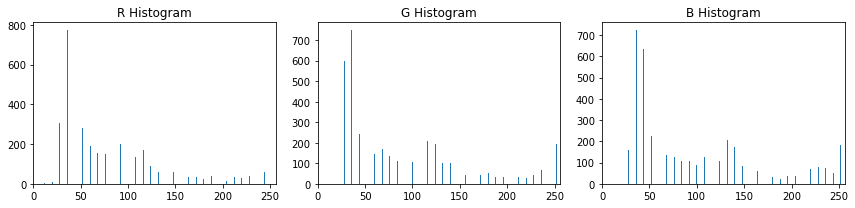

In [6]:
rh, gh, bh, bincen, feature_vec = color_hist(test_pos_img, nbins=32, plot=True)

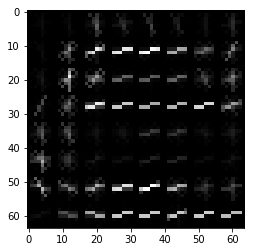

In [7]:
pix_per_cell = 8
cell_per_block = 2
orient = 9

features, hog_image = get_hog_features(
    cv2.cvtColor(test_pos_img, cv2.COLOR_RGB2LUV)[:,:,0],
    orientations=9, 
    pixels_per_cell=8, 
    cells_per_block=2, 
    vis=True
)

plt.imshow(hog_image, cmap='gray')